# Reguralization in CNN networks
- we are going to compare various approaches to regularizarion in neural networks,
- we will use standard image classification task with CNN networks.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

model_args = {}
# we will use batch size of 64 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 64
# learning rate is how fast it will descend
model_args['lr'] = .07
# the number of epochs is the number of times you go through the full dataset
model_args['epochs'] = 20
# L2 (ridge) penalty
model_args['L2_lambda'] = 5.e-3
# L1 (LASSO) penalty
model_args['L1_lambda'] = 2.e-4

### Define problem
- we are going to use CIFAR-10 [dataset](https://www.cs.toronto.edu/~kriz/cifar.html) of 32x32 color images to train image classifier,
- in order to test various regularizations our vanilla CNN classifier should be overfitted.

### Download the dataset

In [4]:
!rm -r ./data
# normalize dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean, std)])

cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# we divide this data into training and validation subsets
train_subset, validation_subset = torch.utils.data.random_split(cifar10_train, [40000, 10000])
test_subset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# subsample to speedup training (colab has notebook lifetime limit)
train_subset = torch.utils.data.Subset(train_subset, range(20000))
validation_subset = torch.utils.data.Subset(validation_subset, range(5000))
test_subset = torch.utils.data.Subset(test_subset, range(5000))

# define dataloaders
loader_kwargs = {'batch_size': model_args['batch_size'],
                 'num_workers': 2,
                 'pin_memory': True,
                 'shuffle': True}
train_loader = torch.utils.data.DataLoader(train_subset, **loader_kwargs)
validation_loader = torch.utils.data.DataLoader(validation_subset, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_subset, **loader_kwargs)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

'rm' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


Files already downloaded and verified
Files already downloaded and verified


### Define CNN models and util methods
- (over)simpified CNN
- VGG11 (definition borrowed from *https://github.com/chengyangfu/pytorch-vgg-cifar10*)


In [5]:
class SimpleCNN(nn.Module):
    '''
    simple CNN model
    '''
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class VGG(nn.Module):
    '''
    VGG model
    '''
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

vgg_cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'vgg22': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 256, 'M', 512, 512, 512, 512, 512, 'M', 512, 512, 512, 512, 512, 'M']
}


def train_with_regularization(model, device, train_loader, optimizer, criterion,
                              epoch_number,
                              L1_lambda,
                              L2_lambda):
    model.train()
    train_loss = 0.
    # get subsequent batches over the data in a given epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        # send data tensors to GPU (or CPU)
        data, target = data.to(device), target.to(device)
        # this will zero out the gradients for this batch
        optimizer.zero_grad()
        # this will execute the forward() function
        output = model(data)
        # calculate loss using c
        loss = criterion(output, target)
        # L2 regularization implemeted by hand
        L2_norm = sum((p**2).sum() for p in model.parameters())
        # L1 regularization
        L1_norm = sum(p.abs().sum() for p in model.parameters())
        #
        loss_regularized = loss + L1_norm*L1_lambda + L2_norm*L2_lambda
        # backpropagate the loss
        loss_regularized.backward()
        # update the model weights (with assumed learning rate)
        optimizer.step()
        train_loss += loss.item()
    print('Train Epoch: {}'.format(epoch_number))
    train_loss /= len(train_loader)
    print('\tTrain set: Average loss: {:.4f}'.format(train_loss))
    return train_loss

def test(model, device, test_loader, criterion, message=None):
    model.eval()
    test_loss = 0.
    correct = 0
    # this is just inference, we don't need to calculate gradients
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # calculate and sum up batch loss
            test_loss += criterion(output, target)
            # get the index of class with the max probability
            prediction = output.argmax(dim=1)
            #_, predicted = torch.max(outputs.data, axis=1)
            # item() returns value of the given tensor
            correct += prediction.eq(target).sum().item()
    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)
    if message is not None:
        print('\t{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            message, test_loss, correct, len(test_loader.dataset), 100.*accuracy))
    return test_loss.cpu(), accuracy

def run_training(model, device, criterion, optimizer, no_epochs,
                 L1_lambda=0.,
                 L2_lambda=0.):
    train_loss = []
    validation_loss = []
    validation_accuracy = []
    test_accuracy = []
    for epoch_number in range(1, no_epochs+1):
        train_loss.append(train_with_regularization(model, device, train_loader,
                                optimizer, criterion, epoch_number,
                                L1_lambda, L2_lambda))
        val_loss, val_acc = test(model, device, validation_loader,
                                criterion, 'Validation set')
        validation_loss.append(val_loss)
        validation_accuracy.append(val_acc)
        # we also collect test accuracies for every epoch
        _, test_acc = test(model, device, test_loader, criterion)
        test_accuracy.append(test_acc)
    # and select test accuracy for the best epoch (with the highest validation accuracy)
    best_accuracy = test_accuracy[np.argmax(validation_accuracy)]
    return train_loss, validation_loss, best_accuracy

def plot_loss(train_loss, validation_loss, title):
    plt.grid(True)
    plt.xlabel("subsequent epochs")
    plt.ylabel('average loss')
    plt.plot(range(1, len(train_loss)+1), train_loss, 'o-', label='training')
    plt.plot(range(1, len(validation_loss)+1), validation_loss, 'o-', label='validation')
    plt.legend()
    plt.title(title)
    plt.show()

### Do the experiments
- without any regularization
- *weigt_decay*, L2 regularization implemeted in optimizer, e.g. Adam or SGD as here: see [discussion](https://discuss.pytorch.org/t/how-does-sgd-weight-decay-work/33105/6)
- L2 and L1 regularization implemeted by hand

Train Epoch: 1
	Train set: Average loss: 2.0169
	Validation set: Average loss: 1.7895, Accuracy: 1654/5000 (33%)
Train Epoch: 2
	Train set: Average loss: 1.6833
	Validation set: Average loss: 1.5181, Accuracy: 2226/5000 (45%)
Train Epoch: 3
	Train set: Average loss: 1.5198
	Validation set: Average loss: 1.4450, Accuracy: 2316/5000 (46%)
Train Epoch: 4
	Train set: Average loss: 1.4189
	Validation set: Average loss: 1.3912, Accuracy: 2465/5000 (49%)
Train Epoch: 5
	Train set: Average loss: 1.3465
	Validation set: Average loss: 1.3136, Accuracy: 2660/5000 (53%)
Train Epoch: 6
	Train set: Average loss: 1.2724
	Validation set: Average loss: 1.5142, Accuracy: 2368/5000 (47%)
Train Epoch: 7
	Train set: Average loss: 1.2153
	Validation set: Average loss: 1.3280, Accuracy: 2680/5000 (54%)
Train Epoch: 8
	Train set: Average loss: 1.1700
	Validation set: Average loss: 1.3870, Accuracy: 2575/5000 (52%)
Train Epoch: 9
	Train set: Average loss: 1.1188
	Validation set: Average loss: 1.3912, Accuracy:

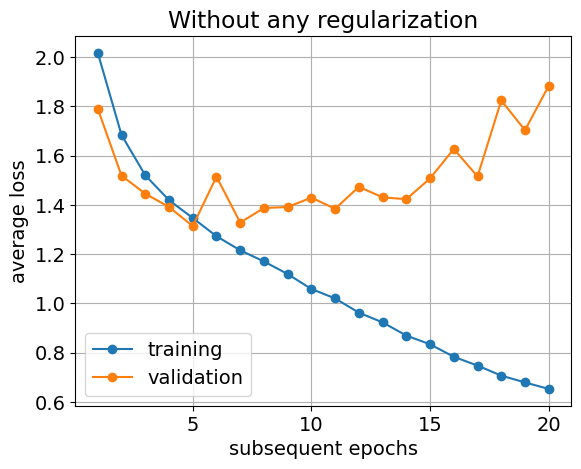

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=model_args['lr'],
                      weight_decay=0.)

train_loss_0, val_loss_0, best_accuracy = run_training(model, device, criterion, optimizer, model_args['epochs'])

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_0, val_loss_0, 'Without any regularization')
model_0_params = [p.detach().cpu().numpy() for p in model.parameters()]

Train Epoch: 1
	Train set: Average loss: 2.0722
	Validation set: Average loss: 1.8646, Accuracy: 1506/5000 (30%)
Train Epoch: 2
	Train set: Average loss: 1.7367
	Validation set: Average loss: 1.5980, Accuracy: 2039/5000 (41%)
Train Epoch: 3
	Train set: Average loss: 1.5925
	Validation set: Average loss: 1.5270, Accuracy: 2247/5000 (45%)
Train Epoch: 4
	Train set: Average loss: 1.4965
	Validation set: Average loss: 1.4816, Accuracy: 2280/5000 (46%)
Train Epoch: 5
	Train set: Average loss: 1.4241
	Validation set: Average loss: 1.3998, Accuracy: 2493/5000 (50%)
Train Epoch: 6
	Train set: Average loss: 1.3599
	Validation set: Average loss: 1.4320, Accuracy: 2400/5000 (48%)
Train Epoch: 7
	Train set: Average loss: 1.3097
	Validation set: Average loss: 1.3833, Accuracy: 2528/5000 (51%)
Train Epoch: 8
	Train set: Average loss: 1.2569
	Validation set: Average loss: 1.3446, Accuracy: 2611/5000 (52%)
Train Epoch: 9
	Train set: Average loss: 1.2214
	Validation set: Average loss: 1.3503, Accuracy:

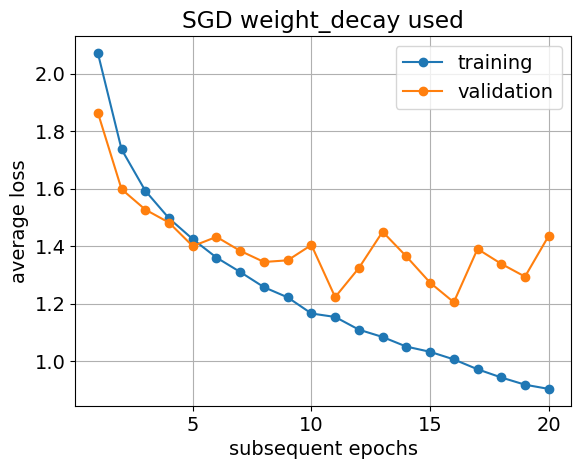

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=model_args['lr'],
                      weight_decay=model_args['L2_lambda'])

train_loss_wd, val_loss_wd, best_accuracy = run_training(model, device, criterion, optimizer, model_args['epochs'])

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_wd, val_loss_wd, 'SGD weight_decay used')
model_wd_params = [p.detach().cpu().numpy() for p in model.parameters()]

Train Epoch: 1
	Train set: Average loss: 2.0729
	Validation set: Average loss: 1.8942, Accuracy: 1516/5000 (30%)
Train Epoch: 2
	Train set: Average loss: 1.7294
	Validation set: Average loss: 1.7625, Accuracy: 1817/5000 (36%)
Train Epoch: 3
	Train set: Average loss: 1.5670
	Validation set: Average loss: 1.5442, Accuracy: 2231/5000 (45%)
Train Epoch: 4
	Train set: Average loss: 1.4648
	Validation set: Average loss: 1.7849, Accuracy: 1947/5000 (39%)
Train Epoch: 5
	Train set: Average loss: 1.4082
	Validation set: Average loss: 1.4227, Accuracy: 2486/5000 (50%)
Train Epoch: 6
	Train set: Average loss: 1.3474
	Validation set: Average loss: 1.4917, Accuracy: 2346/5000 (47%)
Train Epoch: 7
	Train set: Average loss: 1.2942
	Validation set: Average loss: 1.8164, Accuracy: 2125/5000 (42%)
Train Epoch: 8
	Train set: Average loss: 1.2595
	Validation set: Average loss: 1.3465, Accuracy: 2569/5000 (51%)
Train Epoch: 9
	Train set: Average loss: 1.2147
	Validation set: Average loss: 1.4287, Accuracy:

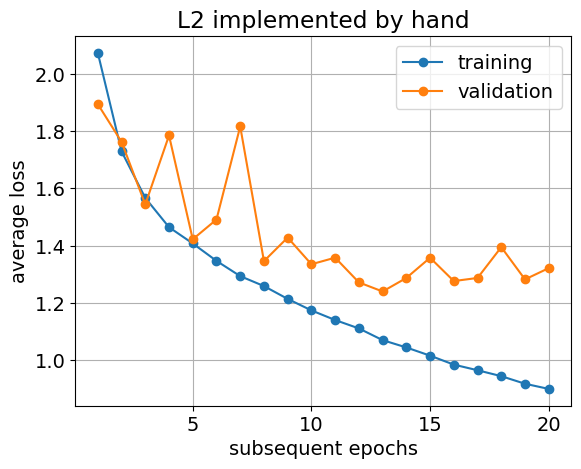

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=model_args['lr'],
                      weight_decay=0.)

train_loss_l2, val_loss_l2, best_accuracy = run_training(model, device, criterion, optimizer, model_args['epochs'],
                                                         L1_lambda=0.,
                                                         L2_lambda=model_args['L2_lambda']/2.)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_l2, val_loss_l2, 'L2 implemented by hand')
model_l2_params = [p.detach().cpu().numpy() for p in model.parameters()]

Train Epoch: 1
	Train set: Average loss: 2.0521
	Validation set: Average loss: 1.8323, Accuracy: 1595/5000 (32%)
Train Epoch: 2
	Train set: Average loss: 1.7365
	Validation set: Average loss: 1.6437, Accuracy: 1949/5000 (39%)
Train Epoch: 3
	Train set: Average loss: 1.5874
	Validation set: Average loss: 1.5211, Accuracy: 2216/5000 (44%)
Train Epoch: 4
	Train set: Average loss: 1.4910
	Validation set: Average loss: 1.5505, Accuracy: 2143/5000 (43%)
Train Epoch: 5
	Train set: Average loss: 1.4033
	Validation set: Average loss: 1.5612, Accuracy: 2128/5000 (43%)
Train Epoch: 6
	Train set: Average loss: 1.3519
	Validation set: Average loss: 1.4323, Accuracy: 2411/5000 (48%)
Train Epoch: 7
	Train set: Average loss: 1.2968
	Validation set: Average loss: 1.3624, Accuracy: 2542/5000 (51%)
Train Epoch: 8
	Train set: Average loss: 1.2500
	Validation set: Average loss: 1.2970, Accuracy: 2681/5000 (54%)
Train Epoch: 9
	Train set: Average loss: 1.2072
	Validation set: Average loss: 1.6367, Accuracy:

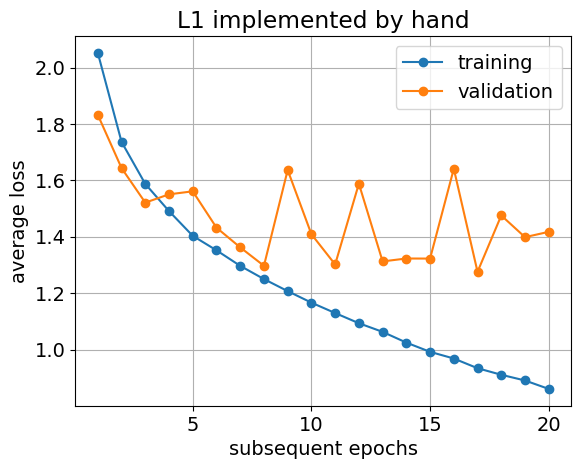

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=model_args['lr'],
                      weight_decay=0.)

train_loss_l1, val_loss_l1, best_accuracy = run_training(model, device, criterion, optimizer, model_args['epochs'],
                                                         L1_lambda=model_args['L1_lambda'],
                                                         L2_lambda=0.)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_l1, val_loss_l1, 'L1 implemented by hand')
model_l1_params = [p.detach().cpu().numpy() for p in model.parameters()]

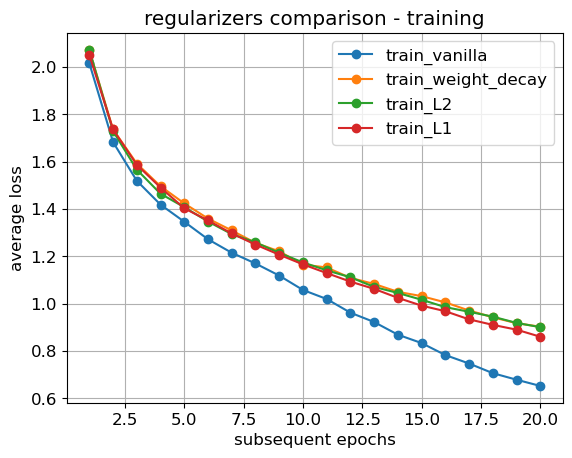

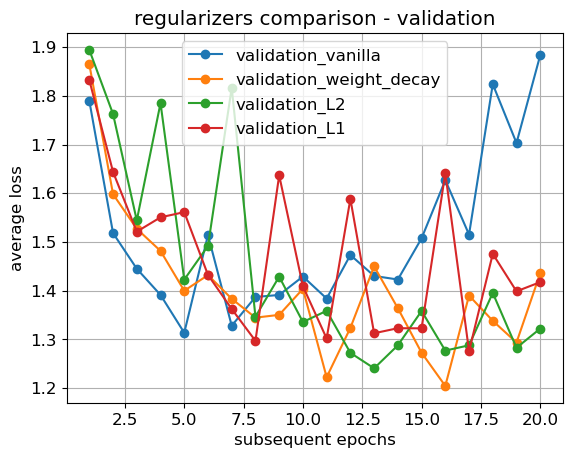

In [8]:
plt.rcParams.update({'font.size': 12})

plt.grid(True)
plt.xlabel("subsequent epochs")
plt.ylabel('average loss')
range_epochs = model_args['epochs']+1
plt.plot(range(1, range_epochs), train_loss_0,  'o-', label='train_vanilla')
plt.plot(range(1, range_epochs), train_loss_wd, 'o-', label='train_weight_decay')
plt.plot(range(1, range_epochs), train_loss_l2, 'o-', label='train_L2')
plt.plot(range(1, range_epochs), train_loss_l1, 'o-', label='train_L1')
plt.legend()
plt.title("regularizers comparison - training")
plt.show()

plt.grid(True)
plt.xlabel("subsequent epochs")
plt.ylabel('average loss')
range_epochs = model_args['epochs']+1
plt.plot(range(1, range_epochs), val_loss_0,  'o-', label='validation_vanilla')
plt.plot(range(1, range_epochs), val_loss_wd, 'o-', label='validation_weight_decay')
plt.plot(range(1, range_epochs), val_loss_l2, 'o-', label='validation_L2')
plt.plot(range(1, range_epochs), val_loss_l1, 'o-', label='validation_L1')
plt.legend()
plt.title("regularizers comparison - validation")
plt.show()

Example weights:

In [9]:
for p in model_0_params:
    print(p.shape)

np.set_printoptions(formatter={'float_kind': "{:.3f}".format})
# parameters for the second from last layer
print("vanilla:\n", model_0_params[-2][0])
print("L2 regularized:\n", model_l2_params[-2][0])
print("L1 regularized:\n", model_l1_params[-2][0])

(6, 3, 5, 5)
(6,)
(16, 6, 5, 5)
(16,)
(120, 400)
(120,)
(80, 120)
(80,)
(10, 80)
(10,)
vanilla:
 [0.036 -0.261 0.166 -0.290 0.057 0.024 -0.065 -0.123 0.117 -0.100 0.239
 -0.063 -0.034 -0.012 -0.407 0.134 0.097 -0.020 0.207 0.045 -0.129 -0.071
 0.200 -0.058 0.127 0.173 -0.261 0.071 0.236 -0.151 -0.325 -0.290 0.161
 0.273 0.156 0.012 0.050 -0.134 -0.014 -0.012 -0.148 -0.172 0.080 0.220
 0.010 -0.193 -0.233 -0.063 0.092 0.039 0.057 0.249 -0.239 -0.119 0.371
 0.175 0.123 -0.111 0.024 0.124 0.077 -0.126 -0.187 -0.021 0.179 -0.061
 -0.190 0.121 -0.221 -0.207 -0.156 0.300 0.051 -0.182 0.296 0.146 0.244
 0.127 0.206 -0.155]
L2 regularized:
 [-0.126 -0.068 0.033 -0.012 0.091 0.417 0.008 -0.108 0.311 0.233 0.088
 0.023 -0.207 0.062 -0.052 -0.239 -0.039 -0.169 0.003 -0.155 -0.051 0.156
 0.013 0.108 -0.272 0.139 0.036 -0.007 -0.058 -0.047 0.073 0.041 -0.006
 -0.022 -0.024 0.149 -0.353 -0.112 -0.101 -0.015 -0.038 -0.146 -0.061
 0.070 0.021 -0.078 -0.115 0.009 0.131 -0.186 0.035 0.168 -0.028 0.149
 

### Tasks to do:

0. Try to play with L2 and L1 *lambdas* do get highest possible accuracy.
- e.g. what if we increase *L1_lambda* to be the same as *L2_lambda*
1. Repeat the calculations but for the VGG11 model.
2. Compare amplitudes (plot histograms?) of model weights for the L2 and L1 case -- is L1 a strong feature selector?

3. Reimplement pytorch [SGD method](https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html#SGD) to get L1 regularization (|w| instead of w**2)

Hint: change line
```python
if weight_decay != 0:
    d_p = d_p.add(param, alpha=weight_decay)
```
to
```python
if weight_decay != 0:
    d_p = d_p.add(torch.sign(param), alpha=weight_decay)
```

Train Epoch: 1
	Train set: Average loss: 2.1353
	Validation set: Average loss: 2.0789, Accuracy: 1013/5000 (20%)
Train Epoch: 2
	Train set: Average loss: 1.9967
	Validation set: Average loss: 2.0038, Accuracy: 1327/5000 (27%)
Train Epoch: 3
	Train set: Average loss: 1.8973
	Validation set: Average loss: 2.1676, Accuracy: 1087/5000 (22%)
Train Epoch: 4
	Train set: Average loss: 1.8322
	Validation set: Average loss: 1.7809, Accuracy: 1587/5000 (32%)
Train Epoch: 5
	Train set: Average loss: 1.7953
	Validation set: Average loss: 2.2907, Accuracy: 1197/5000 (24%)
Train Epoch: 6
	Train set: Average loss: 1.7791
	Validation set: Average loss: 1.7771, Accuracy: 1714/5000 (34%)
Train Epoch: 7
	Train set: Average loss: 1.7613
	Validation set: Average loss: 1.7152, Accuracy: 1665/5000 (33%)
Train Epoch: 8
	Train set: Average loss: 1.7529
	Validation set: Average loss: 1.8532, Accuracy: 1395/5000 (28%)
Train Epoch: 9
	Train set: Average loss: 1.7426
	Validation set: Average loss: 1.8371, Accuracy:

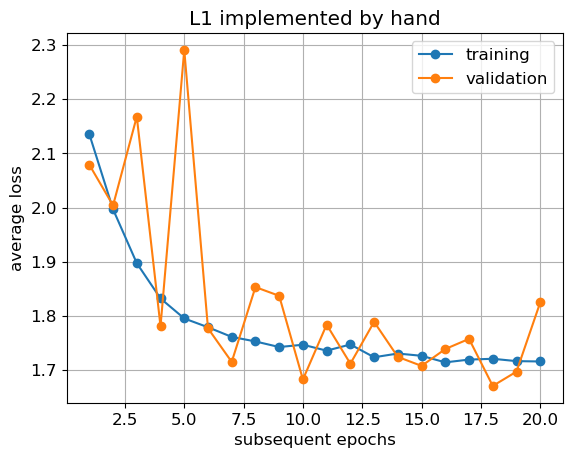

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=model_args['lr'],
                      weight_decay=0.)

train_loss_l1, val_loss_l1, best_accuracy = run_training(model, device, criterion, optimizer, model_args['epochs'],
                                                         L1_lambda=2.e-4,
                                                         L2_lambda=0.)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_l1, val_loss_l1, 'L1 implemented by hand')
model_l1_params = [p.detach().cpu().numpy() for p in model.parameters()]

Train Epoch: 1
	Train set: Average loss: 2.3027
	Validation set: Average loss: 2.3028, Accuracy: 457/5000 (9%)
Train Epoch: 2
	Train set: Average loss: 2.3026
	Validation set: Average loss: 2.3026, Accuracy: 501/5000 (10%)
Train Epoch: 3
	Train set: Average loss: 2.3026
	Validation set: Average loss: 2.3025, Accuracy: 498/5000 (10%)
Train Epoch: 4
	Train set: Average loss: 2.3026
	Validation set: Average loss: 2.3026, Accuracy: 510/5000 (10%)
Train Epoch: 5
	Train set: Average loss: 2.3026
	Validation set: Average loss: 2.3025, Accuracy: 498/5000 (10%)
Train Epoch: 6
	Train set: Average loss: 2.3026
	Validation set: Average loss: 2.3026, Accuracy: 517/5000 (10%)
Train Epoch: 7
	Train set: Average loss: 2.3026
	Validation set: Average loss: 2.3025, Accuracy: 510/5000 (10%)
Train Epoch: 8
	Train set: Average loss: 2.3026
	Validation set: Average loss: 2.3025, Accuracy: 520/5000 (10%)
Train Epoch: 9
	Train set: Average loss: 2.3026
	Validation set: Average loss: 2.3026, Accuracy: 510/5000

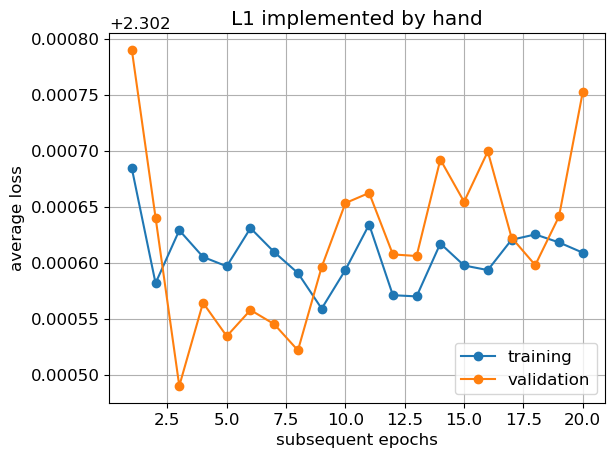

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=model_args['lr'],
                      weight_decay=0.)

train_loss_l1, val_loss_l1, best_accuracy = run_training(model, device, criterion, optimizer, model_args['epochs'],
                                                         L1_lambda=2.e-2,
                                                         L2_lambda=0.)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_l1, val_loss_l1, 'L1 implemented by hand')
model_l1_params = [p.detach().cpu().numpy() for p in model.parameters()]

Train Epoch: 1
	Train set: Average loss: 2.3024
	Validation set: Average loss: 2.3028, Accuracy: 471/5000 (9%)
Train Epoch: 2
	Train set: Average loss: 2.3027
	Validation set: Average loss: 2.3029, Accuracy: 501/5000 (10%)
Train Epoch: 3
	Train set: Average loss: 2.3027
	Validation set: Average loss: 2.3029, Accuracy: 498/5000 (10%)
Train Epoch: 4
	Train set: Average loss: 2.3028
	Validation set: Average loss: 2.3029, Accuracy: 504/5000 (10%)
Train Epoch: 5
	Train set: Average loss: 2.3026
	Validation set: Average loss: 2.3029, Accuracy: 498/5000 (10%)
Train Epoch: 6
	Train set: Average loss: 2.3028
	Validation set: Average loss: 2.3030, Accuracy: 498/5000 (10%)
Train Epoch: 7
	Train set: Average loss: 2.3027
	Validation set: Average loss: 2.3025, Accuracy: 504/5000 (10%)
Train Epoch: 8
	Train set: Average loss: 2.3028
	Validation set: Average loss: 2.3028, Accuracy: 498/5000 (10%)
Train Epoch: 9
	Train set: Average loss: 2.3028
	Validation set: Average loss: 2.3028, Accuracy: 504/5000

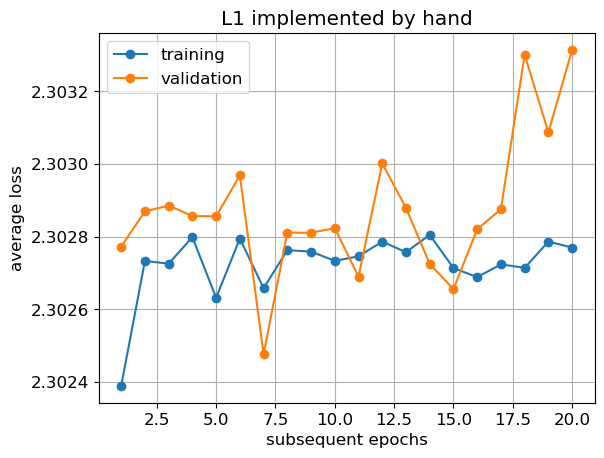

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=model_args['lr'],
                      weight_decay=0.)

train_loss_l1, val_loss_l1, best_accuracy = run_training(model, device, criterion, optimizer, model_args['epochs'],
                                                         L1_lambda=0,
                                                         L2_lambda=5.e-2)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_l1, val_loss_l1, 'L1 implemented by hand')
model_l1_params = [p.detach().cpu().numpy() for p in model.parameters()]

Train Epoch: 1
	Train set: Average loss: 2.3025
	Validation set: Average loss: 2.3027, Accuracy: 504/5000 (10%)
Train Epoch: 2
	Train set: Average loss: 2.3026
	Validation set: Average loss: 2.3026, Accuracy: 504/5000 (10%)
Train Epoch: 3
	Train set: Average loss: 2.3027
	Validation set: Average loss: 2.3026, Accuracy: 520/5000 (10%)
Train Epoch: 4
	Train set: Average loss: 2.3026
	Validation set: Average loss: 2.3028, Accuracy: 498/5000 (10%)
Train Epoch: 5
	Train set: Average loss: 2.3027
	Validation set: Average loss: 2.3026, Accuracy: 489/5000 (10%)
Train Epoch: 6
	Train set: Average loss: 2.3026
	Validation set: Average loss: 2.3027, Accuracy: 457/5000 (9%)
Train Epoch: 7
	Train set: Average loss: 2.3026
	Validation set: Average loss: 2.3027, Accuracy: 501/5000 (10%)
Train Epoch: 8
	Train set: Average loss: 2.3026
	Validation set: Average loss: 2.3029, Accuracy: 471/5000 (9%)
Train Epoch: 9
	Train set: Average loss: 2.3026
	Validation set: Average loss: 2.3025, Accuracy: 504/5000 

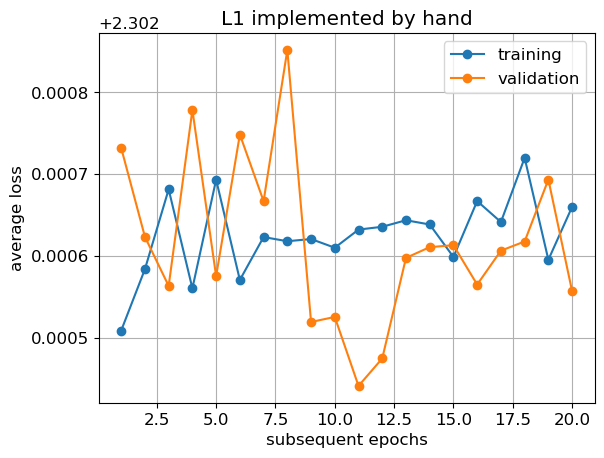

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=model_args['lr'],
                      weight_decay=0.)

train_loss_l1, val_loss_l1, best_accuracy = run_training(model, device, criterion, optimizer, model_args['epochs'],
                                                         L1_lambda=0,
                                                         L2_lambda=5.e-1)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_l1, val_loss_l1, 'L1 implemented by hand')
model_l1_params = [p.detach().cpu().numpy() for p in model.parameters()]

Overall Impact:

    If you increase L1_lambda to be the same as L2_lambda, the combined effect would be a balance between encouraging sparsity (from L1) and controlling the magnitude of weights (from L2).
    The model would still try to keep weights small overall (due to L2 regularization), but it would also try to push many weights to zero (due to increased L1 regularization).

Training Dynamics:

    Increasing both regularization terms equally might result in a more conservative model with simpler decision boundaries.
    It could also potentially lead to slower convergence during training, as the combined effect of strong L1 and L2 regularization might require more iterations to find an optimal solution.

Robustness to Noise:

    The combined regularization could enhance the model's robustness to noise in the data by encouraging simpler models with fewer non-essential features.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG(make_layers(vgg_cfg['vgg11'])).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=model_args['lr'],
                      weight_decay=0.)

train_loss_0, val_loss_0, best_accuracy = run_training(model, device, criterion, optimizer, model_args['epochs'])

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_0, val_loss_0, 'Without any regularization')
model_0_params = [p.detach().cpu().numpy() for p in model.parameters()]

Train Epoch: 1
	Train set: Average loss: 2.2315
	Validation set: Average loss: 2.1883, Accuracy: 874/5000 (17%)


KeyboardInterrupt: 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG(make_layers(vgg_cfg['vgg11'])).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=model_args['lr'],
                      weight_decay=model_args['L2_lambda'])

train_loss_wd, val_loss_wd, best_accuracy = run_training(model, device, criterion, optimizer, model_args['epochs'])

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_wd, val_loss_wd, 'SGD weight_decay used')
model_wd_params = [p.detach().cpu().numpy() for p in model.parameters()]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG(make_layers(vgg_cfg['vgg11'])).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=model_args['lr'],
                      weight_decay=0.)

train_loss_l2, val_loss_l2, best_accuracy = run_training(model, device, criterion, optimizer, model_args['epochs'],
                                                         L1_lambda=0.,
                                                         L2_lambda=model_args['L2_lambda']/2.)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_l2, val_loss_l2, 'L2 implemented by hand')
model_l2_params = [p.detach().cpu().numpy() for p in model.parameters()]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG(make_layers(vgg_cfg['vgg11'])).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=model_args['lr'],
                      weight_decay=0.)

train_loss_l1, val_loss_l1, best_accuracy = run_training(model, device, criterion, optimizer, model_args['epochs'],
                                                         L1_lambda=model_args['L1_lambda'],
                                                         L2_lambda=0.)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_l1, val_loss_l1, 'L1 implemented by hand')
model_l1_params = [p.detach().cpu().numpy() for p in model.parameters()]

In [ ]:
plt.rcParams.update({'font.size': 12})

plt.grid(True)
plt.xlabel("subsequent epochs")
plt.ylabel('average loss')
range_epochs = model_args['epochs']+1
plt.plot(range(1, range_epochs), train_loss_0,  'o-', label='train_vanilla')
plt.plot(range(1, range_epochs), train_loss_wd, 'o-', label='train_weight_decay')
plt.plot(range(1, range_epochs), train_loss_l2, 'o-', label='train_L2')
plt.plot(range(1, range_epochs), train_loss_l1, 'o-', label='train_L1')
plt.legend()
plt.title("regularizers comparison - training")
plt.show()

plt.grid(True)
plt.xlabel("subsequent epochs")
plt.ylabel('average loss')
range_epochs = model_args['epochs']+1
plt.plot(range(1, range_epochs), val_loss_0,  'o-', label='validation_vanilla')
plt.plot(range(1, range_epochs), val_loss_wd, 'o-', label='validation_weight_decay')
plt.plot(range(1, range_epochs), val_loss_l2, 'o-', label='validation_L2')
plt.plot(range(1, range_epochs), val_loss_l1, 'o-', label='validation_L1')
plt.legend()
plt.title("regularizers comparison - validation")
plt.show()

In [19]:
for p in model_0_params:
    print(p.shape)

np.set_printoptions(formatter={'float_kind': "{:.3f}".format})
# parameters for the second from last layer
print("vanilla:\n", model_0_params[-2][0])
print("L2 regularized:\n", model_l2_params[-2][0])
print("L1 regularized:\n", model_l1_params[-2][0])

(64, 3, 3, 3)
(64,)
(128, 64, 3, 3)
(128,)
(256, 128, 3, 3)
(256,)
(256, 256, 3, 3)
(256,)
(512, 256, 3, 3)
(512,)
(512, 512, 3, 3)
(512,)
(512, 512, 3, 3)
(512,)
(512, 512, 3, 3)
(512,)
(512, 512)
(512,)
(512, 512)
(512,)
(10, 512)
(10,)
vanilla:
 [0.154 0.003 0.063 -0.126 0.023 -0.036 -0.001 0.159 0.180 -0.044 -0.031
 0.259 0.002 -0.180 -0.019 -0.139 -0.003 -0.054 -0.031 0.056 0.007 -0.021
 0.065 0.090 -0.052 0.078 0.122 -0.020 -0.007 -0.028 0.009 -0.078 0.145
 0.045 -0.006 -0.004 -0.016 0.077 -0.179 0.126 0.041 0.089 0.039 0.013
 0.034 -0.036 0.164 0.048 0.101 -0.048 0.037 0.056 0.126 -0.005 0.008
 0.130 -0.036 -0.058 -0.020 -0.075 -0.040 -0.003 0.010 -0.222 -0.104
 -0.049 -0.031 0.001 -0.002 0.010 -0.000 0.024 -0.052 -0.007 0.105 -0.003
 0.031 0.010 0.056 -0.039 0.245 0.023 0.048 0.046 0.028 0.030 -0.015 0.031
 0.031 0.023 0.165 0.004 0.069 -0.033 0.096 0.036 0.010 0.075 -0.138 0.031
 -0.023 -0.162 -0.171 0.037 -0.066 0.025 0.008 -0.081 -0.212 0.014 0.060
 0.006 -0.108 0.093 0.021 

In [10]:
[0.154,-0.003]

[0.154, -0.003]

In [18]:
vanilla = [0.154,0.003,0.063,-0.126,0.023,-0.036,-0.001,0.159,0.180,-0.044,-0.031,0.259,0.002,-0.180,-0.019,-0.139,-0.003,-0.054,-0.031,0.056,0.007,-0.021,0.065,0.090,-0.052,0.078,0.122,-0.020,-0.007,-0.028,0.009,-0.078,0.145,0.045,-0.006,-0.004,-0.016,0.077,-0.179,0.126,0.041,0.089,0.039,0.013,0.034,-0.036,0.164,0.048,0.101,-0.048,0.037,0.056,0.126,-0.005,0.008,0.130,-0.036,-0.058,-0.020,-0.075,-0.040,-0.003,0.010,-0.222,-0.104,-0.049,-0.031,0.001,-0.002,0.010,-0.000,0.024,-0.052,-0.007,0.105,-0.003,0.031,0.010,0.056,-0.039,0.245,0.023,0.048,0.046,0.028,0.030,-0.015,0.031,0.031,0.023,0.165,0.004,0.069,-0.033,0.096,0.036,0.010,0.075,-0.138,0.031,-0.023,-0.162,-0.171,0.037,-0.066,0.025,0.008,-0.081,-0.212,0.014,0.060,0.006,-0.108,0.093,0.021,-0.049,-0.033,0.066,-0.014,0.040,-0.018,-0.032,0.005,-0.058,0.018,0.032,-0.035,-0.042,0.040,-0.022,-0.077,0.092,0.017,0.001,0.001,0.045,0.143,-0.108,0.080,-0.090,-0.054,0.009,0.051,0.131,0.041,0.036,0.019,-0.008,0.008,-0.018,-0.039,-0.092,-0.072,0.067,-0.046,0.001,0.037,-0.012,0.020,0.017,0.189,-0.001,-0.103,0.039,0.069,-0.028,-0.047,-0.013,0.127,-0.044,-0.093,0.006,-0.051,0.139,-0.026,0.008,0.000,-0.059,0.027,-0.107,0.041,0.043,0.052,-0.117,0.003,-0.037,0.031,0.032,0.137,-0.008,-0.047,0.008,-0.026,0.183,-0.051,-0.011,0.008,0.098,0.001,0.089,-0.052,-0.012,0.027,0.034,0.055,-0.032,0.051,0.054,0.042,-0.054,0.031,0.017,0.006,-0.089,-0.049,-0.086,-0.011,-0.031,-0.006,-0.019,-0.084,-0.034,-0.018,-0.014,-0.090,-0.032,-0.022,0.014,-0.031,0.016,-0.022,-0.017,-0.105,0.197,-0.020,-0.018,-0.003,0.057,0.014,0.065,0.027,-0.050,-0.079,-0.031,0.084,0.011,-0.030,0.003,0.016,0.003,-0.121,-0.175,0.009,0.010,0.033,0.011,0.007,0.103,0.133,0.042,-0.110,0.043,0.118,-0.023,-0.127,0.001,-0.059,-0.080,-0.031,0.091,-0.009,0.034,0.093,-0.026,0.013,0.148,0.057,-0.106,0.045,-0.201,0.034,-0.069,0.006,0.051,-0.011,0.043,0.015,-0.014,0.033,-0.056,-0.108,-0.029,-0.006,0.101,-0.025,0.073,-0.019,0.034,-0.092,0.106,-0.107,0.032,0.037,-0.030,0.045,-0.051,0.118,0.028,0.035,-0.144,-0.064,-0.146,-0.067,0.037,0.009,-0.005,0.021,0.019,0.110,0.021,0.016,-0.090,-0.189,0.100,-0.100,-0.057,0.064,-0.032,-0.014,-0.058,0.007,0.077,0.047,0.015,0.058,0.004,0.053,0.036,-0.071,-0.002,-0.145,-0.087,0.037,-0.003,0.021,0.018,0.035,-0.017,-0.059,-0.069,-0.014,-0.043,0.127,-0.041,0.070,0.020,-0.030,-0.037,0.112,0.010,-0.000,0.008,0.025,-0.006,0.026,-0.038,0.014,-0.011,-0.063,-0.020,-0.059,0.007,-0.062,0.143,0.006,0.016,-0.028,-0.057,0.041,0.051,-0.025,-0.036,-0.048,0.051,-0.024,0.027,-0.019,0.106,-0.063,0.050,0.060,0.035,-0.122,-0.042,0.013,0.001,-0.014,0.060,-0.033,0.078,-0.021,-0.079,0.045,0.023,-0.006,0.029,-0.011,0.069,-0.020,-0.012,-0.012,-0.073,0.083,0.062,0.005,-0.003,0.024,-0.013,0.025,0.024,0.005,0.109,0.096,-0.009,0.035,0.004,0.032,0.015,-0.006,0.038,-0.020,0.025,0.041,0.023,-0.008,-0.043,0.038,0.046,-0.014,-0.056,0.017,-0.011,-0.095,0.090,-0.091,-0.064,-0.088,-0.035,-0.006,-0.013,0.002,-0.116,-0.042,0.012,-0.059,-0.037,0.058,0.029,-0.026,-0.217,-0.065,-0.011,-0.012,0.064,0.000,0.080,0.044,-0.056,0.135,-0.108,-0.037,0.115,0.001,0.069,-0.006,-0.086,-0.046,0.136,0.009,-0.009,0.054,0.196,-0.047,0.057,0.072,-0.110,0.004,0.061,-0.004,0.099,0.022,-0.092,-0.037,0.025,-0.059,0.123,-0.045,0.036,-0.037,-0.058,0.032,-0.012,0.020,0.042,0.016,-0.031,-0.023,0.222,0.081,0.047,-0.010,0.061]
L2_regularized = [-0.014,-0.013,0.032,-0.022,-0.004,-0.039,-0.020,0.025,-0.053,-0.043,-0.021,-0.001,-0.024,-0.127,-0.003,0.002,-0.004,-0.010,0.004,-0.025,0.060,0.009,-0.020,0.057,0.026,-0.023,-0.030,-0.042,-0.009,-0.002,-0.000,-0.007,0.015,0.025,0.031,-0.051,-0.001,0.030,0.039,0.010,-0.033,-0.105,-0.025,0.005,-0.009,0.001,-0.031,-0.042,-0.000,-0.027,-0.038,0.013,0.089,-0.011,-0.023,0.030,0.047,0.029,-0.002,-0.023,-0.038,-0.034,-0.018,-0.018,0.008,-0.042,0.037,0.059,0.033,-0.002,-0.037,0.004,-0.079,0.012,0.014,-0.021,0.059,0.004,0.006,-0.012,-0.069,0.053,0.048,0.039,0.004,0.034,0.021,-0.028,0.107,0.085,-0.040,-0.024,0.000,0.025,-0.051,0.001,0.029,0.021,0.019,-0.059,-0.080,-0.011,0.020,-0.015,0.021,0.033,0.057,-0.018,0.054,0.039,-0.009,-0.024,0.006,-0.081,-0.015,0.037,0.036,-0.047,-0.001,-0.000,0.003,-0.008,0.005,0.002,-0.004,0.016,0.111,0.027,-0.031,-0.015,0.060,0.004,-0.010,-0.092,0.071,-0.047,0.015,0.016,0.010,-0.024,-0.001,-0.010,-0.054,-0.039,0.005,0.003,-0.017,-0.007,0.065,-0.057,-0.020,-0.016,-0.004,0.016,-0.025,-0.001,-0.010,0.021,-0.034,0.029,-0.008,-0.040,-0.009,0.009,-0.035,0.050,0.034,-0.027,0.033,0.003,0.006,-0.059,0.013,-0.072,0.051,0.001,0.097,0.002,-0.012,-0.004,0.001,0.003,0.032,-0.013,-0.015,0.045,0.000,-0.020,0.023,-0.015,0.091,-0.028,0.000,-0.021,-0.058,-0.039,0.014,0.007,-0.093,-0.013,-0.017,-0.007,0.003,-0.011,0.059,0.011,0.034,0.024,0.001,0.024,-0.005,0.014,-0.001,-0.033,0.011,-0.018,0.035,0.002,0.048,-0.016,-0.006,-0.033,-0.017,0.083,0.040,0.011,0.072,-0.008,-0.011,-0.021,0.061,-0.009,-0.002,-0.042,-0.014,0.106,0.117,-0.012,0.150,-0.003,-0.024,-0.025,-0.011,-0.004,-0.008,-0.065,-0.053,0.099,-0.088,-0.012,0.011,0.117,-0.089,0.035,-0.052,-0.035,0.056,-0.007,0.046,-0.007,-0.012,0.003,0.066,0.016,-0.025,0.011,0.004,0.171,0.001,-0.014,-0.017,-0.004,0.008,-0.034,-0.010,-0.020,-0.001,-0.024,0.107,-0.010,-0.059,-0.003,0.032,0.011,-0.001,-0.000,0.011,-0.003,-0.022,-0.012,-0.053,0.002,-0.008,0.038,0.021,-0.006,0.078,0.014,-0.007,0.012,-0.017,-0.051,0.003,0.003,0.010,-0.019,-0.067,0.022,-0.051,-0.030,0.057,-0.014,0.003,-0.007,-0.000,0.053,0.050,0.013,0.040,0.019,-0.034,-0.021,0.006,-0.034,0.033,0.030,0.002,0.096,-0.026,0.066,0.024,0.017,-0.050,0.037,-0.118,-0.068,0.028,0.038,-0.052,-0.057,-0.012,-0.090,0.004,-0.021,0.030,0.032,-0.040,0.002,-0.054,-0.031,-0.005,-0.008,0.001,-0.014,-0.050,-0.007,-0.031,0.072,0.009,-0.061,0.039,-0.052,-0.133,-0.009,-0.049,-0.002,0.004,0.005,-0.028,0.075,0.052,0.079,0.066,-0.046,0.109,-0.054,0.006,-0.027,0.029,-0.000,0.005,-0.037,-0.067,0.055,0.015,-0.013,-0.075,0.004,-0.030,0.007,0.009,0.037,0.042,0.026,-0.013,-0.012,-0.024,0.005,-0.012,-0.012,0.079,-0.010,0.049,0.075,-0.007,-0.040,-0.004,-0.024,0.046,-0.004,0.000,0.021,0.088,0.040,-0.032,0.068,0.058,0.036,0.051,0.028,0.008,-0.044,0.029,0.025,-0.053,-0.004,-0.083,-0.123,-0.062,-0.012,0.056,0.040,-0.004,-0.002,0.084,-0.043,-0.009,0.085,-0.004,-0.022,0.030,-0.007,0.009,-0.027,-0.017,0.039,-0.045,0.001,-0.033,-0.010,-0.032,0.008,-0.008,0.003,0.113,0.049,0.108,0.023,0.016,-0.028,-0.075,0.029,-0.004,-0.011,0.014,-0.005,0.064,-0.029,-0.002,-0.028,0.013,-0.087,-0.044,-0.013,-0.021,0.033,0.058,0.048,-0.030,-0.038,0.003,-0.011,-0.019,-0.064,-0.105,-0.025,0.127,0.043,-0.061,0.071,0.005,-0.045,-0.023,-0.019,-0.023,0.002,-0.026,0.072,-0.006,-0.033,-0.019,0.035,-0.054,-0.003,0.062,0.054,-0.009,-0.055,-0.006,-0.004,-0.096,0.003]


In [16]:
L2_regularized = [-0.014,-0.013,0.032,-0.022,-0.004,-0.039,-0.020,0.025,-0.053,-0.043,-0.021,-0.001,-0.024,-0.127,-0.003,0.002,-0.004,-0.010,0.004,-0.025,0.060,0.009,-0.020,0.057,0.026,-0.023,-0.030,-0.042,-0.009,-0.002,-0.000,-0.007,0.015,0.025,0.031,-0.051,-0.001,0.030,0.039,0.010,-0.033,-0.105,-0.025,0.005,-0.009,0.001,-0.031,-0.042,-0.000,-0.027,-0.038,0.013,0.089,-0.011,-0.023,0.030,0.047,0.029,-0.002,-0.023,-0.038,-0.034,-0.018,-0.018,0.008,-0.042,0.037,0.059,0.033,-0.002,-0.037,0.004,-0.079,0.012,0.014,-0.021,0.059,0.004,0.006,-0.012,-0.069,0.053,0.048,0.039,0.004,0.034,0.021,-0.028,0.107,0.085,-0.040,-0.024,0.000,0.025,-0.051,0.001,0.029,0.021,0.019,-0.059,-0.080,-0.011,0.020,-0.015,0.021,0.033,0.057,-0.018,0.054,0.039,-0.009,-0.024,0.006,-0.081,-0.015,0.037,0.036,-0.047,-0.001,-0.000,0.003,-0.008,0.005,0.002,-0.004,0.016,0.111,0.027,-0.031,-0.015,0.060,0.004,-0.010,-0.092,0.071,-0.047,0.015,0.016,0.010,-0.024,-0.001,-0.010,-0.054,-0.039,0.005,0.003,-0.017,-0.007,0.065,-0.057,-0.020,-0.016,-0.004,0.016,-0.025,-0.001,-0.010,0.021,-0.034,0.029,-0.008,-0.040,-0.009,0.009,-0.035,0.050,0.034,-0.027,0.033,0.003,0.006,-0.059,0.013,-0.072,0.051,0.001,0.097,0.002,-0.012,-0.004,0.001,0.003,0.032,-0.013,-0.015,0.045,0.000,-0.020,0.023,-0.015,0.091,-0.028,0.000,-0.021,-0.058,-0.039,0.014,0.007,-0.093,-0.013,-0.017,-0.007,0.003,-0.011,0.059,0.011,0.034,0.024,0.001,0.024,-0.005,0.014,-0.001,-0.033,0.011,-0.018,0.035,0.002,0.048,-0.016,-0.006,-0.033,-0.017,0.083,0.040,0.011,0.072,-0.008,-0.011,-0.021,0.061,-0.009,-0.002,-0.042,-0.014,0.106,0.117,-0.012,0.150,-0.003,-0.024,-0.025,-0.011,-0.004,-0.008,-0.065,-0.053,0.099,-0.088,-0.012,0.011,0.117,-0.089,0.035,-0.052,-0.035,0.056,-0.007,0.046,-0.007,-0.012,0.003,0.066,0.016,-0.025,0.011,0.004,0.171,0.001,-0.014,-0.017,-0.004,0.008,-0.034,-0.010,-0.020,-0.001,-0.024,0.107,-0.010,-0.059,-0.003,0.032,0.011,-0.001,-0.000,0.011,-0.003,-0.022,-0.012,-0.053,0.002,-0.008,0.038,0.021,-0.006,0.078,0.014,-0.007,0.012,-0.017,-0.051,0.003,0.003,0.010,-0.019,-0.067,0.022,-0.051,-0.030,0.057,-0.014,0.003,-0.007,-0.000,0.053,0.050,0.013,0.040,0.019,-0.034,-0.021,0.006,-0.034,0.033,0.030,0.002,0.096,-0.026,0.066,0.024,0.017,-0.050,0.037,-0.118,-0.068,0.028,0.038,-0.052,-0.057,-0.012,-0.090,0.004,-0.021,0.030,0.032,-0.040,0.002,-0.054,-0.031,-0.005,-0.008,0.001,-0.014,-0.050,-0.007,-0.031,0.072,0.009,-0.061,0.039,-0.052,-0.133,-0.009,-0.049,-0.002,0.004,0.005,-0.028,0.075,0.052,0.079,0.066,-0.046,0.109,-0.054,0.006,-0.027,0.029,-0.000,0.005,-0.037,-0.067,0.055,0.015,-0.013,-0.075,0.004,-0.030,0.007,0.009,0.037,0.042,0.026,-0.013,-0.012,-0.024,0.005,-0.012,-0.012,0.079,-0.010,0.049,0.075,-0.007,-0.040,-0.004,-0.024,0.046,-0.004,0.000,0.021,0.088,0.040,-0.032,0.068,0.058,0.036,0.051,0.028,0.008,-0.044,0.029,0.025,-0.053,-0.004,-0.083,-0.123,-0.062,-0.012,0.056,0.040,-0.004,-0.002,0.084,-0.043,-0.009,0.085,-0.004,-0.022,0.030,-0.007,0.009,-0.027,-0.017,0.039,-0.045,0.001,-0.033,-0.010,-0.032,0.008,-0.008,0.003,0.113,0.049,0.108,0.023,0.016,-0.028,-0.075,0.029,-0.004,-0.011,0.014,-0.005,0.064,-0.029,-0.002,-0.028,0.013,-0.087,-0.044,-0.013,-0.021,0.033,0.058,0.048,-0.030,-0.038,0.003,-0.011,-0.019,-0.064,-0.105,-0.025,0.127,0.043,-0.061,0.071,0.005,-0.045,-0.023,-0.019,-0.023,0.002,-0.026,0.072,-0.006,-0.033,-0.019,0.035,-0.054,-0.003,0.062,0.054,-0.009,-0.055,-0.006,-0.004,-0.096,0.003]


In [19]:
L1_regularized = [0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.046,0.000,-0.000,0.055,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.006,0.015,-0.000,-0.000,-0.000,-0.000,0.000,0.001,0.007,-0.000,-0.000,0.000,-0.000,-0.096,0.000,-0.000,-0.000,0.000,-0.007,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.074,0.126,-0.000,0.000,-0.000,-0.000,-0.105,-0.000,0.025,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.069,-0.000,-0.000,-0.014,0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.031,0.000,0.000,-0.011,-0.000,0.000,0.067,-0.000,0.024,0.000,0.009,-0.000,0.000,0.000,-0.000,0.066,-0.000,0.000,0.070,-0.000,-0.000,0.032,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.031,0.000,-0.000,-0.020,0.000,0.000,0.000,0.000,0.000,0.000,-0.029,0.000,-0.080,-0.000,0.000,-0.000,0.000,0.007,-0.051,0.000,0.000,0.093,-0.000,-0.000,0.000,0.000,-0.123,0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.061,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.064,-0.018,0.000,-0.000,0.000,0.000,0.001,-0.000,0.007,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.002,0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.048,0.125,0.000,-0.000,0.000,0.000,0.256,-0.000,-0.016,-0.000,0.000,-0.000,0.001,-0.000,0.000,-0.000,0.000,-0.006,0.000,-0.000,0.000,0.001,0.335,0.000,0.010,0.000,-0.000,0.000,0.017,0.000,0.005,-0.000,0.000,-0.032,-0.000,0.000,-0.000,-0.000,0.044,0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.053,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.167,-0.000,-0.000,0.234,0.000,-0.000,0.000,-0.000,0.010,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,-0.014,0.000,-0.000,-0.000,0.000,-0.000,0.025,0.000,0.000,0.000,-0.087,0.000,-0.094,0.178,0.000,-0.000,0.487,0.000,0.158,-0.084,-0.000,-0.000,0.003,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,-0.249,-0.000,0.059,0.000,0.000,-0.000,-0.017,-0.000,0.000,-0.000,0.000,0.001,-0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,-0.054,0.000,-0.000,-0.000,-0.000,-0.000,-0.005,-0.000,0.000,0.136,0.000,-0.000,-0.000,-0.044,-0.000,-0.000,0.000,0.000,0.066,0.000,0.073,-0.000,0.000,0.000,-0.000,-0.000,0.000,0.056,-0.000,0.009,-0.000,0.141,0.000,-0.585,-0.000,0.000,-0.000,0.023,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.062,0.033,-0.000,0.124,-0.000,-0.000,0.192,0.000,0.136,-0.000,0.001,0.000,-0.042,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.019,-0.000,-0.032,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.010,-0.000,0.000,0.007,-0.000,-0.043,0.026,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.178,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.030,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.016,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.035,-0.000,-0.305,0.000,0.000,0.132,-0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.022,0.000,0.009,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.022,-0.000,-0.000,0.000,-0.000,0.023,0.002,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.001,0.000,0.000,-0.043,0.066,-0.013,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.036,0.000,0.000,0.000,-0.000,-0.000]


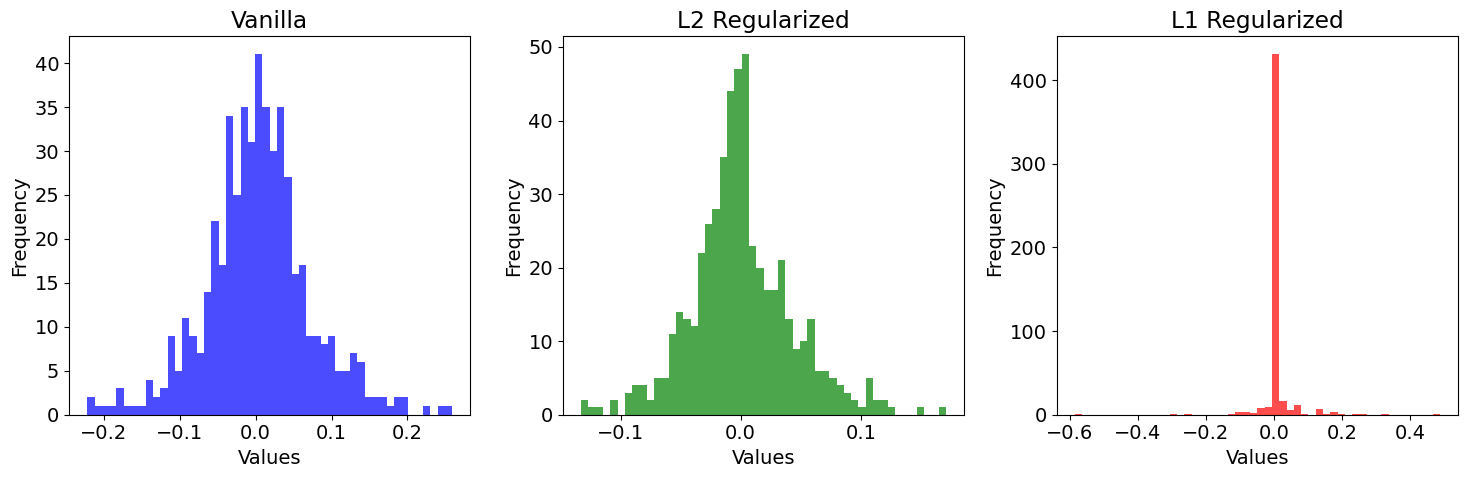

In [24]:
plt.figure(figsize=(15, 5))

# Histogramme pour 'vanilla'
plt.subplot(1, 3, 1)
plt.hist(vanilla, bins=50, color='blue', alpha=0.7)
plt.title('Vanilla')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Histogramme pour 'L2 regularized'
plt.subplot(1, 3, 2)
plt.hist(L2_regularized, bins=50, color='green', alpha=0.7)
plt.title('L2 Regularized')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Histogramme pour 'L1 regularized'
plt.subplot(1, 3, 3)
plt.hist(L1_regularized, bins=50, color='red', alpha=0.7)
plt.title('L1 Regularized')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Ajustement de l'espace entre les sous-graphes
plt.tight_layout()

# Affichage du graphique
plt.show()

In [26]:
len(L1_regularized)

512

In [ ]:
import torch
from torch import Tensor
from .optimizer import (Optimizer, _use_grad_for_differentiable, _default_to_fused_or_foreach,
                        _differentiable_doc, _foreach_doc, _maximize_doc, _fused_doc)
from typing import List, Optional

__all__ = ['SGD', 'sgd']



[docs]class SGD(Optimizer):
    def __init__(self, params, lr=1e-3, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False, *, maximize: bool = False, foreach: Optional[bool] = None,
                 differentiable: bool = False, fused: Optional[bool] = None):
        if lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if momentum < 0.0:
            raise ValueError(f"Invalid momentum value: {momentum}")
        if weight_decay < 0.0:
            raise ValueError(f"Invalid weight_decay value: {weight_decay}")

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov,
                        maximize=maximize, foreach=foreach,
                        differentiable=differentiable, fused=fused)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super().__init__(params, defaults)

        if fused:
            self._step_supports_amp_scaling = True
            if differentiable:
                raise RuntimeError("`fused` does not support `differentiable`")
            if foreach:
                raise RuntimeError("`fused` and `foreach` cannot be `True` together.")

    def __setstate__(self, state):
        super().__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)
            group.setdefault('maximize', False)
            group.setdefault('foreach', None)
            group.setdefault('differentiable', False)
            group.setdefault('fused', False)

    def _init_group(self, group, params_with_grad, d_p_list, momentum_buffer_list):
        has_sparse_grad = False

        for p in group['params']:
            if p.grad is not None:
                params_with_grad.append(p)
                d_p_list.append(p.grad)
                if p.grad.is_sparse:
                    has_sparse_grad = True

                state = self.state[p]
                momentum_buffer_list.append(state.get('momentum_buffer'))

        return has_sparse_grad


[docs]    @_use_grad_for_differentiable
    def step(self, closure=None):
        """Performs a single optimization step.

        Args:
            closure (Callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            d_p_list = []
            momentum_buffer_list = []

            has_sparse_grad = self._init_group(group, params_with_grad, d_p_list, momentum_buffer_list)

            sgd(params_with_grad,
                d_p_list,
                momentum_buffer_list,
                weight_decay=group['weight_decay'],
                momentum=group['momentum'],
                lr=group['lr'],
                dampening=group['dampening'],
                nesterov=group['nesterov'],
                maximize=group['maximize'],
                has_sparse_grad=has_sparse_grad,
                foreach=group['foreach'],
                fused=group['fused'],
                grad_scale=getattr(self, "grad_scale", None),
                found_inf=getattr(self, "found_inf", None))

            # update momentum_buffers in state
            for p, momentum_buffer in zip(params_with_grad, momentum_buffer_list):
                state = self.state[p]
                state['momentum_buffer'] = momentum_buffer

        return loss



SGD.__doc__ = r"""Implements stochastic gradient descent (optionally with momentum).

    .. math::
       \begin{aligned}
            &\rule{110mm}{0.4pt}                                                                 \\
            &\textbf{input}      : \gamma \text{ (lr)}, \: \theta_0 \text{ (params)}, \: f(\theta)
                \text{ (objective)}, \: \lambda \text{ (weight decay)},                          \\
            &\hspace{13mm} \:\mu \text{ (momentum)}, \:\tau \text{ (dampening)},
            \:\textit{ nesterov,}\:\textit{ maximize}                                     \\[-1.ex]
            &\rule{110mm}{0.4pt}                                                                 \\
            &\textbf{for} \: t=1 \: \textbf{to} \: \ldots \: \textbf{do}                         \\
            &\hspace{5mm}g_t           \leftarrow   \nabla_{\theta} f_t (\theta_{t-1})           \\
            &\hspace{5mm}\textbf{if} \: \lambda \neq 0                                           \\
            &\hspace{10mm} g_t \leftarrow g_t + \lambda  \theta_{t-1}                            \\
            &\hspace{5mm}\textbf{if} \: \mu \neq 0                                               \\
            &\hspace{10mm}\textbf{if} \: t > 1                                                   \\
            &\hspace{15mm} \textbf{b}_t \leftarrow \mu \textbf{b}_{t-1} + (1-\tau) g_t           \\
            &\hspace{10mm}\textbf{else}                                                          \\
            &\hspace{15mm} \textbf{b}_t \leftarrow g_t                                           \\
            &\hspace{10mm}\textbf{if} \: \textit{nesterov}                                       \\
            &\hspace{15mm} g_t \leftarrow g_{t} + \mu \textbf{b}_t                             \\
            &\hspace{10mm}\textbf{else}                                                   \\[-1.ex]
            &\hspace{15mm} g_t  \leftarrow  \textbf{b}_t                                         \\
            &\hspace{5mm}\textbf{if} \: \textit{maximize}                                          \\
            &\hspace{10mm}\theta_t \leftarrow \theta_{t-1} + \gamma g_t                   \\[-1.ex]
            &\hspace{5mm}\textbf{else}                                                    \\[-1.ex]
            &\hspace{10mm}\theta_t \leftarrow \theta_{t-1} - \gamma g_t                   \\[-1.ex]
            &\rule{110mm}{0.4pt}                                                          \\[-1.ex]
            &\bf{return} \:  \theta_t                                                     \\[-1.ex]
            &\rule{110mm}{0.4pt}                                                          \\[-1.ex]
       \end{aligned}

    Nesterov momentum is based on the formula from
    `On the importance of initialization and momentum in deep learning`__.
    """ + fr"""
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        momentum (float, optional): momentum factor (default: 0)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        dampening (float, optional): dampening for momentum (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)
        {_maximize_doc}
        {_foreach_doc}
        {_differentiable_doc}
        {_fused_doc}
    """ + r"""

    Example:
        >>> # xdoctest: +SKIP
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()

    __ http://www.cs.toronto.edu/%7Ehinton/absps/momentum.pdf

    .. note::
        The implementation of SGD with Momentum/Nesterov subtly differs from
        Sutskever et. al. and implementations in some other frameworks.

        Considering the specific case of Momentum, the update can be written as

        .. math::
            \begin{aligned}
                v_{t+1} & = \mu * v_{t} + g_{t+1}, \\
                p_{t+1} & = p_{t} - \text{lr} * v_{t+1},
            \end{aligned}

        where :math:`p`, :math:`g`, :math:`v` and :math:`\mu` denote the
        parameters, gradient, velocity, and momentum respectively.

        This is in contrast to Sutskever et. al. and
        other frameworks which employ an update of the form

        .. math::
            \begin{aligned}
                v_{t+1} & = \mu * v_{t} + \text{lr} * g_{t+1}, \\
                p_{t+1} & = p_{t} - v_{t+1}.
            \end{aligned}

        The Nesterov version is analogously modified.

        Moreover, the initial value of the momentum buffer is set to the
        gradient value at the first step. This is in contrast to some other
        frameworks that initialize it to all zeros.

    """


def sgd(params: List[Tensor],
        d_p_list: List[Tensor],
        momentum_buffer_list: List[Optional[Tensor]],
        # kwonly args with defaults are not supported by functions compiled with torchscript issue #70627
        # setting this as kwarg for now as functional API is compiled by torch/distributed/optim
        has_sparse_grad: bool = None,
        foreach: Optional[bool] = None,
        fused: Optional[bool] = None,
        grad_scale: Optional[Tensor] = None,
        found_inf: Optional[Tensor] = None,
        *,
        weight_decay: float,
        momentum: float,
        lr: float,
        dampening: float,
        nesterov: bool,
        maximize: bool):
    r"""Functional API that performs SGD algorithm computation.

    See :class:`~torch.optim.SGD` for details.
    """

    # Respect when the user inputs False/True for foreach or fused. We only want to change
    # the default when neither have been user-specified. Note that we default to foreach
    # and pass False to use_fused. This is not a mistake--we want to give the fused impl
    # bake-in time before making it the default, even if it is typically faster.
    if foreach is None and fused is None:
        # why must we be explicit about an if statement for torch.jit.is_scripting here?
        # because JIT can't handle Optionals nor fancy conditionals when scripting
        if not torch.jit.is_scripting():
            fused, foreach = _default_to_fused_or_foreach(params, differentiable=False, use_fused=False)
        else:
            foreach = False
            fused = False
    if foreach is None:
        foreach = False
    if fused is None:
        fused = False

    if foreach and torch.jit.is_scripting():
        raise RuntimeError('torch.jit.script not supported with foreach optimizers')
    if fused and torch.jit.is_scripting():
        raise RuntimeError('torch.jit.script not supported with fused optimizers')

    if foreach and not torch.jit.is_scripting():
        func = _multi_tensor_sgd
    elif fused and not torch.jit.is_scripting():
        func = _fused_sgd
    else:
        func = _single_tensor_sgd

    func(params,
         d_p_list,
         momentum_buffer_list,
         weight_decay=weight_decay,
         momentum=momentum,
         lr=lr,
         dampening=dampening,
         nesterov=nesterov,
         has_sparse_grad=has_sparse_grad,
         maximize=maximize,
         grad_scale=grad_scale,
         found_inf=found_inf)

def _single_tensor_sgd(params: List[Tensor],
                       d_p_list: List[Tensor],
                       momentum_buffer_list: List[Optional[Tensor]],
                       grad_scale: Optional[Tensor],
                       found_inf: Optional[Tensor],
                       *,
                       weight_decay: float,
                       momentum: float,
                       lr: float,
                       dampening: float,
                       nesterov: bool,
                       maximize: bool,
                       has_sparse_grad: bool):
    assert grad_scale is None and found_inf is None

    for i, param in enumerate(params):
        d_p = d_p_list[i] if not maximize else -d_p_list[i]

        if weight_decay != 0:
            d_p = d_p.add(torch.sign(param), alpha=weight_decay)

        if momentum != 0:
            buf = momentum_buffer_list[i]

            if buf is None:
                buf = torch.clone(d_p).detach()
                momentum_buffer_list[i] = buf
            else:
                buf.mul_(momentum).add_(d_p, alpha=1 - dampening)

            if nesterov:
                d_p = d_p.add(buf, alpha=momentum)
            else:
                d_p = buf

        param.add_(d_p, alpha=-lr)


def _multi_tensor_sgd(params: List[Tensor],
                      grads: List[Tensor],
                      momentum_buffer_list: List[Optional[Tensor]],
                      grad_scale: Optional[Tensor],
                      found_inf: Optional[Tensor],
                      *,
                      weight_decay: float,
                      momentum: float,
                      lr: float,
                      dampening: float,
                      nesterov: bool,
                      maximize: bool,
                      has_sparse_grad: bool):
    assert grad_scale is None and found_inf is None

    if len(params) == 0:
        return

    grouped_tensors = Optimizer._group_tensors_by_device_and_dtype([params, grads, momentum_buffer_list], with_indices=True)
    for ((device_params, device_grads, device_momentum_buffer_list), indices) in grouped_tensors.values():
        device_has_sparse_grad = has_sparse_grad and any(grad.is_sparse for grad in device_grads)

        if maximize:
            device_grads = torch._foreach_neg(device_grads)

        if weight_decay != 0:
            # Re-use the intermediate memory (device_grads) already allocated for maximize
            if maximize:
                torch._foreach_add_(device_grads, device_params, alpha=weight_decay)
            else:
                device_grads = torch._foreach_add(device_grads, device_params, alpha=weight_decay)

        if momentum != 0:
            bufs = []

            all_states_with_momentum_buffer = True
            for i in range(len(device_momentum_buffer_list)):
                if device_momentum_buffer_list[i] is None:
                    all_states_with_momentum_buffer = False
                    break
                else:
                    bufs.append(device_momentum_buffer_list[i])

            if all_states_with_momentum_buffer:
                torch._foreach_mul_(bufs, momentum)
                torch._foreach_add_(bufs, device_grads, alpha=1 - dampening)
            else:
                bufs = []
                for i in range(len(device_momentum_buffer_list)):
                    if device_momentum_buffer_list[i] is None:
                        buf = device_momentum_buffer_list[i] = momentum_buffer_list[indices[i]] = \
                            torch.clone(device_grads[i]).detach()
                    else:
                        buf = device_momentum_buffer_list[i]
                        buf.mul_(momentum).add_(device_grads[i], alpha=1 - dampening)

                    bufs.append(buf)

            if nesterov:
                torch._foreach_add_(device_grads, bufs, alpha=momentum)
            else:
                device_grads = bufs

        if not device_has_sparse_grad:
            torch._foreach_add_(device_params, device_grads, alpha=-lr)
        else:
            # foreach APIs don't support sparse
            for i in range(len(device_params)):
                device_params[i].add_(device_grads[i], alpha=-lr)


def _fused_sgd(
    params: List[Tensor],
    grads: List[Tensor],
    momentum_buffer_list: List[Optional[Tensor]],
    grad_scale: Optional[Tensor],
    found_inf: Optional[Tensor],
    *,
    weight_decay: float,
    momentum: float,
    lr: float,
    dampening: float,
    nesterov: bool,
    maximize: bool,
    has_sparse_grad: bool,
) -> None:
    if not params:
        return
    if has_sparse_grad:
        raise RuntimeError("`_fused_sgd` does not support sparse gradients")
    grad_scale_dict = {grad_scale.device: grad_scale} if grad_scale is not None else None
    found_inf_dict = {found_inf.device: found_inf} if found_inf is not None else None

    no_momentum_buffer = momentum == 0
    is_first_step = all(t is None for t in momentum_buffer_list) and not no_momentum_buffer
    if is_first_step:
        for i, g in enumerate(grads):
            momentum_buffer_list[i] = torch.empty_like(g)
    grouped_tensors = Optimizer._group_tensors_by_device_and_dtype(
        [params, grads, momentum_buffer_list], with_indices=False)
    for (device, dtype), ((device_params, device_grads, device_momentum_buffer_list), _) in grouped_tensors.items():
        device_grad_scale, device_found_inf = None, None
        if grad_scale is not None:
            if device not in grad_scale_dict:
                grad_scale_dict[device] = grad_scale.to(device)
            device_grad_scale = grad_scale_dict[device]
        if found_inf is not None:
            if device not in found_inf_dict:
                found_inf_dict[device] = found_inf.to(device)
            device_found_inf = found_inf_dict[device]
        torch._fused_sgd_(
            device_params,
            device_grads,
            [] if no_momentum_buffer else device_momentum_buffer_list,
            weight_decay=weight_decay,
            momentum=momentum,
            lr=lr,
            dampening=dampening,
            nesterov=nesterov,
            maximize=maximize,
            is_first_step=is_first_step,
            grad_scale=device_grad_scale,
            found_inf=device_found_inf,
        )